# Librerías y rutas

Importa el módulo "drive" de la biblioteca "google.colab" y monta el Google Drive en la ruta "/content/drive". Permitiendo acceder a los archivos de nuestro Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importa los módulos/librerias necesarios: "os" para funciones relacionadas con el sistema operativo, "tensorflow" para la biblioteca de aprendizaje automático, "numpy" para operaciones numéricas y "matplotlib.pyplot" para visualización de datos.

In [ ]:
import os
import tensorflow as tf
import numpy as np   
import matplotlib.pyplot as plt

Define la ruta principal donde se encuentran los archivos en Google Drive.

In [ ]:
rutaPrincipal = '/content/drive/MyDrive/9° Semestre/RNA & DEEP LEARNING/Semana 17'

Define las rutas de entrada y salida para los conjuntos de datos (imagenes a utilizar) de noche y día respectivamente.

In [ ]:
rutaEntrada = rutaPrincipal + '/dataset/noche'
rutaSalida = rutaPrincipal + '/dataset/dia'

Define la ruta para guardar los checkpoints (puntos de guardado) del modelo.

In [ ]:
rutaCheckpoint = rutaPrincipal + '/checkpoints'

# Randomizar el dataset

Utiliza el comando de la terminal "ls" para obtener la lista de nombres de archivos en la ruta de entrada y luego muestra los nombres de los archivos.

In [ ]:
imgurls = !ls -1 '{rutaEntrada}'
print(imgurls)

['10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


Define el número total de imágenes en el conjunto de datos y calcula el número de imágenes de entrenamiento como el 80% del total.

In [ ]:
n = 200 # Cantidad de imagenes usadas del dataset
train_n = round(n * 0.8)

Realiza una copia aleatoria de los nombres de archivos y los mezcla de manera aleatoria. Luego divide los nombres de archivos en conjuntos de entrenamiento y prueba. Finalmente, imprime el número total de imágenes y los tamaños de los conjuntos de entrenamiento y prueba.

In [ ]:
randurls = np.copy(imgurls)
np.random.seed(23)
np.random.shuffle(randurls)
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]
print(len(imgurls), len(tr_urls), len(ts_urls))

17 17 0


# Manejo de dataset

Define las dimensiones deseadas de ancho y alto para las imágenes del dataset.

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

Define una función para redimensionar las imágenes de entrada y salida a la altura y ancho especificados.

In [ ]:
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  return inimg, tgimg

Define una función para normalizar las imágenes en el rango [-1, 1].

In [ ]:
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  return inimg, tgimg

Define una función para realizar transformaciones aleatorias en las imágenes. Primero redimensiona las imágenes a un tamaño ligeramente más grande, luego las recorta al tamaño deseado. También hay una probabilidad del 50% de voltear horizontalmente las imágenes.

In [ ]:
@tf.function()
def random_jitter(inimg, tgimg): 
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  stacked_image = tf.stack([inimg, tgimg], axis=0) # Apilar las imágenes.
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  inimg, tgimg = cropped_image[0], cropped_image[1]
  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
  return inimg, tgimg

Define una función para cargar una imagen específica y aplicar transformaciones si se indica. La función decodifica los archivos de imagen, los redimensiona, aplica transformaciones aleatorias (si se solicitan) y los normaliza.

In [ ]:
def load_image(filename, augment=True):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaEntrada + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaSalida + '/' + filename)), tf.float32)[..., :3]
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    inimg, tgimg = normalize(inimg, tgimg)
  return inimg, tgimg

Define una función para cargar una imagen de entrenamiento específica. 

In [ ]:
def load_train_image(filename):
  return load_image(filename, True)

Define una función para cargar una imagen de prueba específica.

In [ ]:
def load_test_image(filename):
  return load_image(filename, False)

Carga una imagen de entrenamiento aleatoria utilizando la función load_train_image y la muestra utilizando plt.imshow. La expresión ((load_train_image(randurls[0])[0]) + 1) / 2 normaliza y ajusta la escala de la imagen para que sea visible en la visualización.

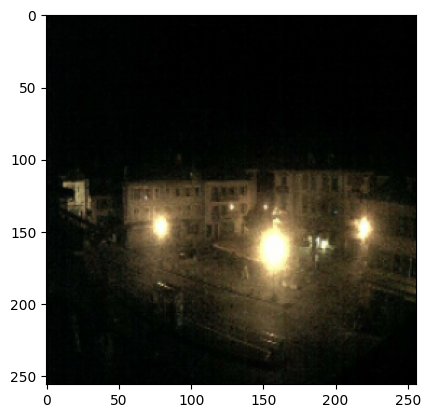

In [ ]:
plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)

Crea un dataset de entrenamiento a partir de los nombres de archivo en el conjunto de datos de entrenamiento.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)

Aplica la función load_train_image a cada elemento del conjunto de datos de entrenamiento utilizando map(). La opción num_parallel_calls=tf.data.experimental.AUTOTUNE permite que TensorFlow determine automáticamente el número óptimo de hilos de ejecución para cargar las imágenes de forma paralela.



In [ ]:
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Agrupa las imágenes cargadas en lotes de tamaño 1 utilizando el método batch() del conjunto de datos de entrenamiento.

In [ ]:
train_dataset = train_dataset.batch(1)

Realiza los mismos tres pasos anteriores pero para el dataset de entrenamiento.

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

Itera sobre los primeros 5 elementos del conjunto de datos de entrenamiento utilizando take(5). Cada iteración obtiene una imagen de entrada (inimg) y una imagen objetivo "salida" (tgimg). Luego, muestra la imagen objetivo utilizando plt.imshow(), normalizando y ajustando la escala de la imagen para una correcta visualización. Finalmente, se muestra la imagen utilizando plt.show().

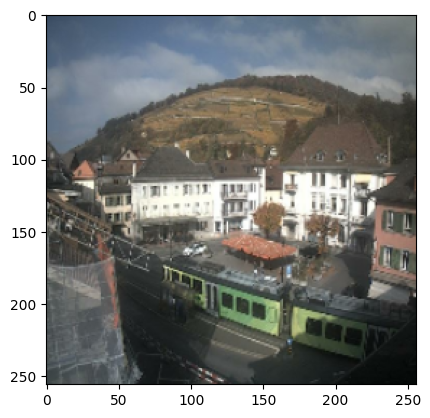

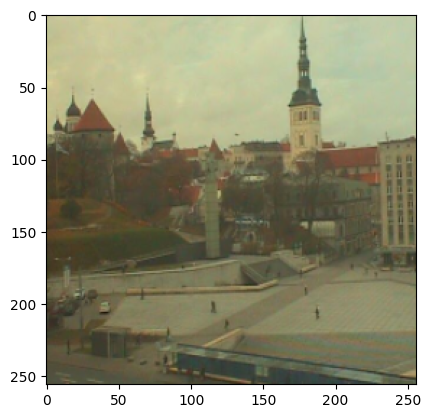

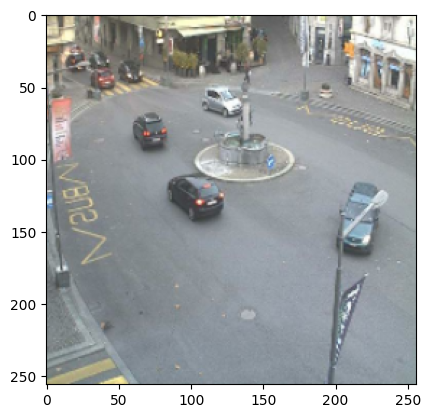

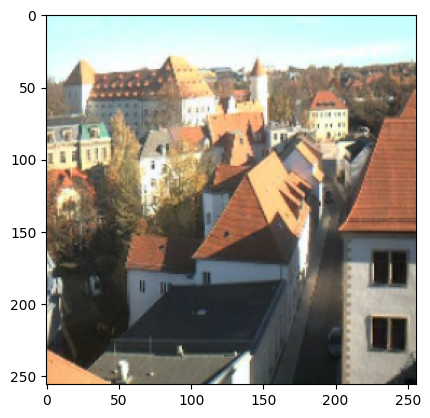

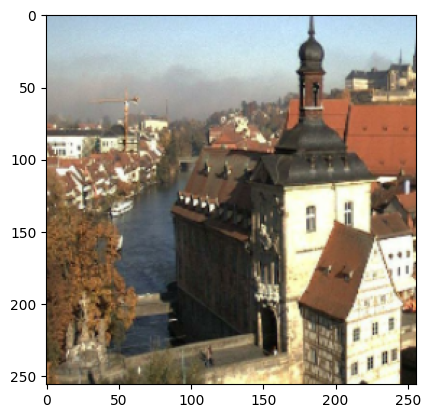

In [ ]:
for inimg, tgimg in train_dataset.take(5):
  plt.imshow(((tgimg[0, ...]) + 1) / 2)
  plt.show()

# Diseño de la arquitectura Pix2Pix

Importa las capas y modelos necesarios de Keras.

In [ ]:
from keras.layers import *
from keras.models import *

Agrega una capa de convolución 2D al modelo result. Esta capa tiene filters filtros, un tamaño de kernel de 4x4, un stride de 2 (para el downsampling), un padding "same" para mantener el tamaño de la imagen y usa el inicializador definido anteriormente. El uso de use_bias=not apply_batchnorm indica que no se utilizará un sesgo si se aplica normalización por lotes.

In [ ]:
def downsample(filters, apply_batchnorm=True):
  result = Sequential() # Crea un modelo secuencial llamado result para contener las capas de la red.
  initializer = tf.random_normal_initializer(0, 0.02) # Define un inicializador para los pesos de la capa de convolución (normalización por lotes)

  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
# Se especifica que se debe aplicar normalización por lotes, agregando una capa de normalización por lotes al modelo result.  
  if apply_batchnorm:
    result.add(BatchNormalization())

  result.add(LeakyReLU()) # Agrega una función de activación LeakyReLU al modelo result.
  
  return result # Devuelve el modelo result creado como salida de la función downsample.

downsample(64) # Esto crea una capa de downsampling con 64 filtros.

Agrega una capa de convolución transpuesta al modelo result. Esta capa tiene filters filtros, un tamaño de kernel de 4x4, un stride de 2 (para el upsampling), un padding "same" para mantener el tamaño de la imagen y usa el inicializador definido anteriormente. El uso de use_bias=False indica que no se utilizará un sesgo en la capa.

In [ ]:
def upsample(filters, apply_dropout=True): # Filters que indica el número de filtros en la capa de convolución transpuesta y apply_dropout que indica si se debe aplicar dropout.

  result = Sequential() # Crea un modelo secuencial para contener las capas de la red.

  initializer = tf.random_normal_initializer(0, 0.02) # Define un inicializador para los pesos de la capa de convolución transpuesta.

 # Capa de convolucion  
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))

  result.add(BatchNormalization()) # Agrega una capa de normalización por lotes al modelo result.

  if apply_dropout: # Si se especifica que se debe aplicar dropout
    result.add(Dropout(0.5)) # Agrega una capa de dropout con una tasa de 0.5 al modelo result.
  
  result.add(ReLU()) # Agrega una función de activación ReLU al modelo result.

  return result # Devuelve el modelo result creado como salida de la función upsample.

Importa las bibliotecas necesarias de TensorFlow.

In [ ]:
from tensorflow.python.ops.numpy_ops.np_math_ops import outer
from tensorflow.python.ops.variables import initialize_all_variables

Define una función y crea una capa de entrada para el generador con una forma flexible que acepta imágenes de cualquier tamaño.

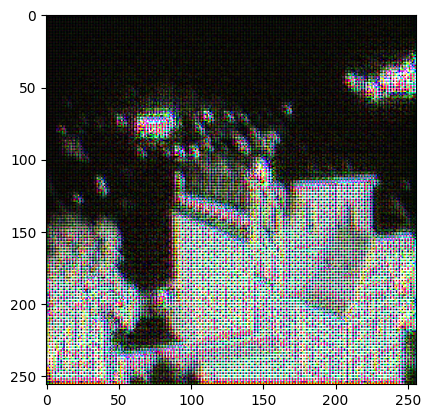

In [ ]:
def Generator():

  inputs = tf.keras.layers.Input(shape=[None,None,3])

# Crea una lista down_stack que contiene capas de downsampling creadas utilizando la función downsample definida anteriormente. 
# La lista contiene capas con diferentes filtros y opciones de normalización por lotes.
  down_stack = [
    downsample(64, apply_batchnorm=False),
    downsample(128),
    downsample(256),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
  ]

# Crea una lista up_stack que contiene capas de upsampling creadas utilizando la función upsample definida anteriormente. 
# La lista contiene capas con diferentes filtros y opciones de dropout.  

  up_stack = [
     upsample(512, apply_dropout=True),
     upsample(512, apply_dropout=True),
     upsample(512, apply_dropout=True),
     upsample(512),
     upsample(256),
     upsample(128),
     upsample(64),         
  ]

  initializer = tf.random_normal_initializer(0, 0.02) # Define un inicializador para los pesos de la última capa de convolución transpuesta.

# Crea una capa de convolución transpuesta final con 3 filtros, un tamaño de kernel de 4x4, un stride de 2 (para el upsampling), 
# un padding "same" para mantener el tamaño de la imagen, un inicializador definido anteriormente y una función de activación tanh.
  last = Conv2DTranspose(filters = 3,
                         kernel_size = 4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh")
  

  x = inputs # Valores de la capa de entrada
  s = [] # Lista vacia

  concat = Concatenate() # Crea una capa de concatenación que se utilizará más adelante.

# Itera sobre la lista down_stack y aplica cada capa de downsampling a la variable x, guardando cada salida intermedia en la lista s.
  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1]) # Invierte la lista s y descarta el último elemento.

# Itera simultáneamente sobre las listas up_stack y s utilizando zip y aplica cada capa de upsampling a la variable x. 
# Luego, concatena la salida de la capa de upsampling con la salida intermedia correspondiente de la lista s utilizando la capa de concatenación.
  for up, sk in zip(up_stack, s):
     
    x = up(x)
    x = concat([x, sk])

  last = last(x) # Aplica la última capa de convolución transpuesta a la variable x y asigna el resultado a la variable last.

  return Model(inputs=inputs, outputs=last) # Devuelve un modelo creado con la capa de entrada y la capa de salida.

# Crea una instancia del generador utilizando la función Generator y luego genera una salida de prueba pasando una imagen preprocesada a través del generador. 
# Finalmente, muestra la imagen generada.
generator = Generator()
gen_output = generator(((inimg+1)*255), training=False)
plt.imshow(gen_output[0,...])

Define una función, crea una dos capas de entrada, una llamada input_img y otra "gener_img" con formas [None, None, 3], lo que indica que puede aceptar imágenes de cualquier tamaño en el ancho y alto, con 3 canales de color (RGB)

TensorShape([1, 16, 16, 1])

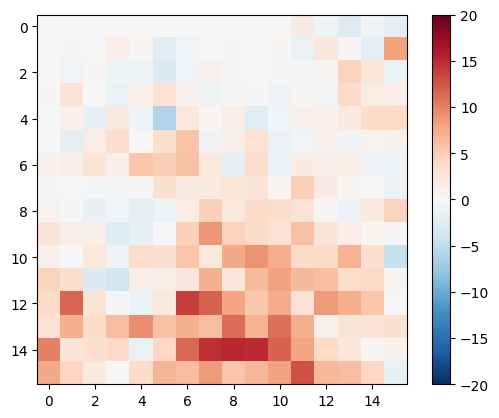

In [ ]:
def Discriminator():

  ini = Input(shape=[None, None, 3], name = "input_img") # Capa de entrada
  gen = Input(shape=[None, None, 3], name = "gener_img") # Capa de entrada

  con = concatenate([ini ,gen]) # Canctena las capas de entrada, a lo largo del eje de los canales de color, creando una sola imagen combinada.
# Se define un inicializador utilizando una distribución normal aleatoria con media 0 y desviación estándar 0.02. 
  initializer = tf.random_normal_initializer(0, 0.02) # Este inicializador se utilizará más adelante en la capa de convolución.  

# Se realiza un muestreo descendente (downsampling), cambiando la cantidad de filtros y se utiliza la capa anterior como entrada.
  down1 = downsample(64, apply_batchnorm=False)(con) #  No se aplica normalización por lotes en esta capa ya que es na variable de entrada.
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)  

# Se crea una capa de convolución 2D utilizando tf.keras.layers.Conv2D. 
# La capa tiene 1 filtro, un tamaño de kernel de 4x4, un paso de 1 y un inicializador definido anteriormente. 
# La capa utiliza la misma cantidad de relleno (padding) en todas las direcciones para mantener el tamaño de la salida igual que la entrada. 
# La entrada de la capa es down4.
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)

  return Model(inputs=[ini, gen], outputs=last) # El modelo incluye todas las capas definidas anteriormente.

discriminator = Discriminator() # El modelo se guarda en esta variable. 

# Se utiliza el modelo discriminator para obtener la salida a partir de dos entradas: inimg es una variable de entrada y gen_output es un tensor. 
# El argumento training=False se utiliza para indicar que el modelo se ejecuta en modo de inferencia.
disc_out = discriminator([((inimg+1)*255), gen_output], training=False)

# Se muestra una imagen utilizando plt.imshow(). 
# La imagen se toma de disc_out en la posición 0 y en la última dimensión (-1). 
# Los valores mínimos y máximos de la imagen se establecen en -20 y 20 respectivamente. El mapa de colores utilizado es 'RdBu_r'. 
# Y se muestra una barra de color asociada a la imagen mostrada anteriormente.
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_out.shape 

Crea una instancia del objeto BinaryCrossentropy de Keras para calcular la pérdida binaria cruzada. El argumento from_logits=True indica que los valores de salida del modelo no están procesados mediante una función de activación sigmoide. Esta instancia se utilizará posteriormente para calcular la pérdida entre las salidas del modelo y las etiquetas verdaderas de clasificación.

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#Perdida del discriminador
def discriminator_loss(disc_real_output, disc_generated_output):

  #Loss de las imagenes reales
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #Loss de las imagenes falsas
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss # Perdida total (suma de la perdidas)

  return total_disc_loss # retorna el valor de la perdida total

In [ ]:
LAMBDA = 100 # declaración del valor la variable LAMBDA

def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output) # Pérdida del generador en un modelo GAN

  # Error absoluto medio
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss) # Perdida total

  return total_gen_loss

In [ ]:
import os # Importamos libreria

#  Se crean optimizadores Adam (algoritmo), con su tasa de aprendizaje del optimizador y valor del hiperparámetro beta
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Se crea un objeto de control de puntos de control (checkpoint) para guardar y restaurar los pesos del modelo.
checkpoint_prefix = os.path.join(rutaCheckpoint, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer, 
                                 generator=generator,
                                 discriminator=discriminator)

# checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed() # Recuperación del modelo a partir de checkpoints

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True) # Predicción utilizando el modelo

# Se proporciona un nombre de archivo para guardar la predicción como una imagen en la ubicación especificada
  if save_filename:
    tf.keras.preprocessing.image.save_img(rutaPrincipal + '/output/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10)) # Se crea una nueva figura para mostrar las imágenes generadas. 

# Se muestra cada imagen junto con su respectivo título (en una sola fila)
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Imagen de Input', 'Imagen real', 'Imagen de predicción']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()     

Entrenamiento del modelo. Calculando gradientes y perdidas, permitiendo actualizar los pesos y optimizar la generación de imagenes.

In [ ]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)


    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

Realiza el entrenamiento de un modelo durante un número específico de épocas. Durante cada época, se realizan pasos de entrenamiento en el dataset de entrenamiento, se generan y muestran imágenes utilizando el generador en el dataset de prueba, y se guarda un punto de control del modelo cada 50 épocas.

In [ ]:
from IPython.display import clear_output # Libreria

def train(dataset, epochs):
  for epoch in range(epochs):

    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)

    imgi = 0  
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi += 1

    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)    

In [ ]:
#Realizar el entrenamiento de la red.
train(train_dataset, 500)

epoch499 - train: 16/17


In [ ]:
#Ruta de guardado del modelo.
rutaModelo = '/content/drive/MyDrive/9° Semestre/RNA & DEEP LEARNING/Semana 17/modelo'
os.chdir(rutaModelo)
!pwd 

/content/drive/MyDrive/9° Semestre/RNA & DEEP LEARNING/Semana 17/modelo


In [ ]:
#Compilar el modelo a partir del generador.
generator.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Guardar el modelo.
generator.save('modelo.h5')

# Predicción de nuevas imágenes

## Nuevos paths

In [ ]:
path ='/content/drive/MyDrive/9° Semestre/RNA & DEEP LEARNING/Semana 17'
rutaModelo = path + '/modelo/modelo.h5'
Modelo = load_model(rutaModelo) # Acceso a la ruta para guardar el modelo generado

rutaPred = path + '/val' #Ruta de las imágenes a predecir
rutaTarget = path + '/valTarget' # Ruta de las imágenes reales para realizar la comparación

## Reajustar tamaño de las imágenes originales a comparar

In [ ]:
# Importación de librerias
import glob
import cv2 
%cd /content/drive/MyDrive/9° Semestre/RNA & DEEP LEARNING/Semana 17 # Acceso a los diferentes archvios de las Semana 17

# Hacemos un ciclo for utilizando la librería glob para recuperar archivos/nombres de ruta que coincidan con un patrón específico.

for allpath in glob.glob(os.path.join(rutaTarget, '*')): # Lea todos los archivos dentro del path, sin importar el nombre
  print("Extrayendo el archivo: {}".format(allpath))
  try:

    lista = allpath.split("/") # Hacemos split para poder separar por "/"
    img = lista[6] # Obtenemos el último valor después del "/" que corresponde al nombre de la imagen con su formato.
    img = cv2.imread(img, cv2.IMREAD_COLOR) # Leemos la imagen mediante CV2.
    img = cv2.resize(img, (256,256), interpolation= cv2.INTER_LINEAR) # Reajustamos el tamaño de las imágenes a 128x128.

    cv2.imwrite(rutaTarget + '/' + lista[6], img) # Guardar la imagen en una ubicación determinada.
    print('Tamaño de imagen reajustado. Imagen guardada en ', rutaTarget) # Mensaje de aviso de reajuste y guardado.

      
  except Exception as e: # En caso de que no pueda realizar el código anterior, arroje un error.
    print(e) # Imprime el error en cuestión.
    continue


[Errno 2] No such file or directory: '/content/drive/MyDrive/9° Semestre/RNA & DEEP LEARNING/Semana 17 # Acceso a los diferentes archvios de las Semana 17'
/content


In [ ]:
# Obtener la lista de nombres de archivos en una ubicación específica
trainImagesUrls = !ls -1 "{rutaPred}"
testImagesUrls = !ls -1 "{rutaTarget}"

IMG_WIDTH = 256 # Ancho
IMG_HEIGHT = 256 # Largo

# Se realiza el reescalado de las imágenes.
def resize(inimg, tgimg, height, width):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

# Normalizar al rango [-1, +1] la imagen.
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

@tf.function()
# Se realiza el data augmentation: random crop (corte()) + flip (rotación).
def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis=0) 
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

# Carga una imagen de un archivo y realiza una serie de operaciones de preprocesamiento en ella.
def load_image(filename, augment=True):
  
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaPred + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(rutaTarget + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg # Retorna las imagenes con preprocesamiento

# Función donde se carga la imagen de entrenamiento.
def load_train_image(filename):
  return load_image(filename, True)

# Función donde se carga la imagen de testeo.
def load_test_image(filename):
  return load_image(filename, False)

Esta función toma un modelo entrenado, datos de entrada y objetivo, genera una imagen utilizando el modelo y muestra las imágenes de entrada, objetivo y generada en una figura de matplotlib. Si se especifica, la imagen generada también se guarda en un archivo.

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(path + '/output/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      #Se obtienen los valores del pixel (entre 0 y 1) para plotearlo.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')

  plt.show()   

# Resultados

Genera y muestra imágenes utilizando un modelo y un subconjunto de datos de entrenamiento. Se procesan 10 pares de imágenes de entrada y objetivo y se muestra el resultado.

In [ ]:
for inp, tar in train_dataset.take(10): # : Itera sobre un subconjunto
  generate_images(Modelo, inp, tar) # Muestra

Output hidden; open in https://colab.research.google.com to view.